In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='gpt2'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'rank, alpha':[]}

In [4]:
lr = 5.0e-5
wd = 0.1
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['rank, alpha'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search gpt2, learning rate 5e-05 wd: 0.1, Lora alpha 8, rank 8


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/software/miniconda3/lib/python3.11/site-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	1.9749	Val Loss:	1.3062	Accuracy:	0.6477	F1:	0.4791
2 / 30: Train Loss:	0.9893	Val Loss:	1.1682	Accuracy:	0.6958	F1:	0.4427
3 / 30: Train Loss:	0.8112	Val Loss:	0.9775	Accuracy:	0.7024	F1:	0.4518
4 / 30: Train Loss:	0.7445	Val Loss:	0.8455	Accuracy:	0.7046	F1:	0.4528
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.23      0.15      0.18       119
      struct       0.73      0.82      0.78       338

    accuracy                           0.65       457
   macro avg       0.48      0.49      0.48       457
weighted avg       0.60      0.65      0.62       457

test results:
              precision    recall  f1-score   support

       bknow       0.25      0.13      0.17        67
      struct       0.74      0.86      0.79       189

    accuracy                           0.67       256
   macro avg       0.49      0.50      0.48       256
weighted av

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/software/miniconda3/lib/python3.11/site-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	1.8151	Val Loss:	1.3633	Accuracy:	0.6740	F1:	0.4383
2 / 30: Train Loss:	0.9427	Val Loss:	1.0563	Accuracy:	0.6958	F1:	0.4486
3 / 30: Train Loss:	0.7779	Val Loss:	0.8790	Accuracy:	0.6980	F1:	0.4497
4 / 30: Train Loss:	0.7096	Val Loss:	0.7583	Accuracy:	0.7002	F1:	0.4566
5 / 30: Train Loss:	0.6743	Val Loss:	0.6862	Accuracy:	0.7090	F1:	0.4609
6 / 30: Train Loss:	0.6328	Val Loss:	0.6441	Accuracy:	0.7133	F1:	0.4631
7 / 30: Train Loss:	0.6038	Val Loss:	0.6198	Accuracy:	0.7243	F1:	0.4623
8 / 30: Train Loss:	0.5940	Val Loss:	0.6069	Accuracy:	0.7352	F1:	0.4609
9 / 30: Train Loss:	0.5803	Val Loss:	0.5976	Accuracy:	0.7352	F1:	0.4609
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.27      0.06      0.10       119
      struct       0.74      0.94      0.83       338

    accuracy                           0.71       457
   macro avg       0.50      0.50      0.46   

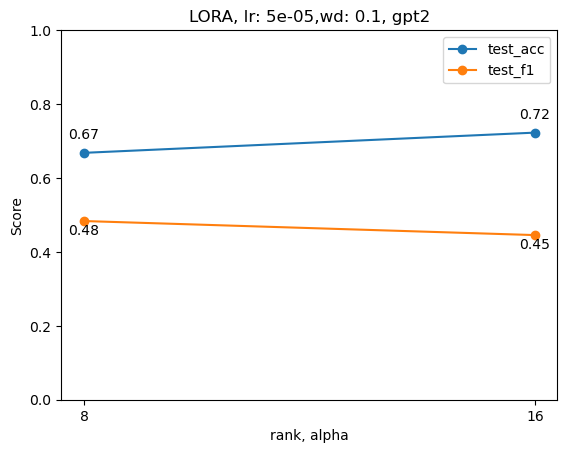

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'LORA, lr: {lr},wd: {wd}, {model_checkpoint}',
                        column='rank, alpha',
                        sci_format=False)

In [6]:
%reset -f